# HW08 - Instrumental Variables (due November 23rd)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [3]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

<AxesSubplot:xlabel='educ', ylabel='lwage'>

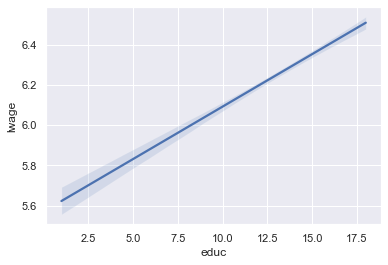

In [4]:
##plot log wages against education
sns.set_theme()
sns.regplot(x='educ', y='lwage', data=df, scatter=False, ci=95)

In [52]:
# Regress log wages (lwage) against education and include controls, use robust standard errors.

# Instruments:
# - nearc2
# - nearc4
#
# Possible confounders:
# - age
# - fatheduc
# - motheduc
# - black
# - smsa
# - south
# - kww
# - iq
# - married
# - exper
#
# All regional dummies could also be included but for now I think 'south' is enough
#
# Analysis
#
# Performing OLS using controls from above yields the following results:
#
# - 'iq' is highly statistically insignificant. It may add considerable amounts of noise
# - 'kww' is statistically significant, but not knowing the specifics of this test it might be better not to include it
# - 'fatheduc' and 'motheduc' surprisingly are not quite statistically significant in this configuration
# - Since 'exper' is calculated using 'educ' and 'age', we can't include it

covariates = ['age', 'black', 'smsa', 'south', 'married']
df = df.dropna(subset=['lwage', 'educ'] + covariates)

exog_vars = ['educ'] + covariates
exog = sm.add_constant(df[exog_vars])

ols = sm.OLS(df['lwage'], exog).fit(cov_type='hc1')
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     138.5
Date:                Mon, 22 Nov 2021   Prob (F-statistic):          6.35e-149
Time:                        12:09:43   Log-Likelihood:                -948.64
No. Observations:                2186   AIC:                             1911.
Df Residuals:                    2179   BIC:                             1951.
Df Model:                           6                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7707      0.091     52.356      0.0

**What are other possible confunders?**

See code comments above for observable confounders.

Other confounders could include:

- Personal skills
- Parent's wealth

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

<AxesSubplot:xlabel='nearc4', ylabel='lwage'>

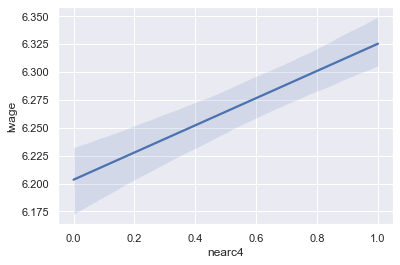

In [53]:
##plot log wages against nearc4

sns.regplot(x='nearc4', y='lwage', data=df, scatter=False, ci=95)

<AxesSubplot:xlabel='nearc4', ylabel='educ'>

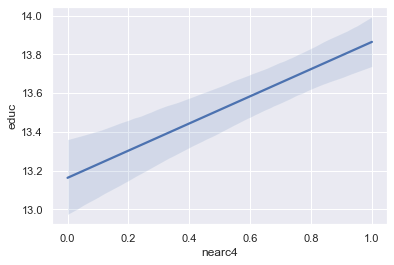

In [54]:
##plot education against nearc4

sns.regplot(x='nearc4', y='educ', data=df, scatter=False, ci=95)

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

I would expect it to be positive, as more years of education increase wages. Furthermore, including an instrument eliminates the cases where the effect is less because there simply wasn't a college nearby.

In [55]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors

# As exper is calculated based on 'age' and 'educ' we will exclude it from the regression.
# Additionally, 'kww' adds too much noise, so we will exclude it as well.
# Age does not seem to be statistically significant either.

fs = sm.OLS(df['educ'], sm.add_constant(df[['nearc4', *covariates]])).fit(cov_type='hc1')
fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     32.17
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           2.75e-37
Time:                        12:11:24   Log-Likelihood:                -5075.4
No. Observations:                2186   AIC:                         1.016e+04
Df Residuals:                    2179   BIC:                         1.020e+04
Df Model:                           6                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4469      0.529     21.629      0.000      10.410      12.484
nearc4         0.3207      0.124      2.586      0.010       0.078       0.564
age            0.0509      0.018      2.788      0.005       0.015       0.087
black         -1.2182      0.157     -7.762      0.000      -1.526      -0.911
smsa           0.7040      0.130      5.426      0.000       0.450       0.958
south         -0.2846      0.118     -2.414      0.016      -0.516      -0.054
married        0.1533      0.025      6.017      0.000       0.103       0.203
==============================================================================
Omnibus:                       17.737   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.049
Skew:                          -0.207   Prob(JB):                     0.000120
Kurtosis:                       3.164   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [56]:
##predict education from the previous regression
df['educhat'] = fs.predict()

In [65]:
##run a regression of log wages on education and controls using robust standard errors

# I assume you mean to regress log wages on predicted education from first stage to get second stage
twosls = sm.OLS(df['lwage'], sm.add_constant(df[['educhat', *covariates]])).fit(cov_type='hc1')
print(twosls.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     112.8
Date:                Mon, 22 Nov 2021   Prob (F-statistic):          3.54e-124
Time:                        12:18:51   Log-Likelihood:                -1005.1
No. Observations:                2186   AIC:                             2024.
Df Residuals:                    2179   BIC:                             2064.
Df Model:                           6                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6340      0.668      6.941      0.0

In [66]:
##compare the 2sls and ols estimates 
print(summary_col([ols, twosls], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'educhat']))


               lwage I lwage II
-------------------------------
educ           0.035           
               (0.003)         
educhat                0.047   
                       (0.058) 
age            0.038   0.038   
               (0.003) (0.004) 
black          -0.156  -0.142  
               (0.024) (0.074) 
const          4.771   4.634   
               (0.091) (0.668) 
married        -0.035  -0.037  
               (0.004) (0.010) 
smsa           0.173   0.163   
               (0.018) (0.050) 
south          -0.125  -0.121  
               (0.018) (0.026) 
R-squared      0.277   0.238   
R-squared Adj. 0.275   0.236   
N              2186    2186    
Standard errors in parentheses.


**What do you think the difference in the estimates is due to?**

The IV estimate is higher by about .01 than the pure OLS estimate. This might be because many people don't get higher education simply because of the lack of a nearby college. By including 'nearc4' as instrument we can get predictions as if those people had a college nearby.

### IV analysis

In [69]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 

exog = sm.add_constant(df[covariates])
ivs = df[['nearc2', 'nearc4']]
iv2sls = IV2SLS(df['lwage'], exog, df['educ'], ivs).fit(cov_type='robust')
print(iv2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                      0.2512
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2491
No. Observations:                2186   F-statistic:                    725.02
Date:                Mon, Nov 22 2021   P-value (F-stat)                0.0000
Time:                        12:22:00   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.4431     0.6634     6.6977     0.0000      3.1429      5.7432
age            0.0367     0.0041     8.9629     0.00

By using only 'nearc4' as instrument the IV estimate is identical to the "manual" one. Adding 'nearc2' increases the estimate by another .02. This indicates that the two instrumental variables are indeed good IV's.